# Bayesian black-box model-predictive control

An Expected Free Energy minimizing agent based on a nonlinear autoregressive model with exogenous input.

## System: ARX

Consider a system generating observations $y_k \in \mathbb{R}$ based on inputs $u_k \in \mathbb{R}$:

$$ y_k = \theta^{\top}x_k + u_k + e_k \, ,$$

where $x_k \in \mathbb{R}^{D}$ is a vector of previous observations and $\theta$ are coefficients. The noise instances $e_k$ are assumed to be zero-mean Gaussian distributed with variance $\sigma^2$.

In [1]:
using Revise
using ForwardDiff
using Optim
using RxInfer
using SpecialFunctions
using LinearAlgebra
using ProgressMeter
using Distributions
using Plots; default(grid=false, label="", linewidth=3,margin=20Plots.pt)

includet("../NARXAgents.jl"); using .NARXAgents
includet("./ARXsystem.jl"); using .ARXsystem

In [2]:
# System parameters
sys_mnoise_sd = 0.01;

# True coefficients
M_in = 2
M_out = 2
M = M_in + M_out
sys_coefficients = [0.0; cos.(π/6 .*(1:M)).*rand(M)./2]

5-element Vector{Float64}:
  0.0
  0.22667885861895382
  0.09956097895754418
  2.5106961393549523e-17
 -0.22977344010452214

In [3]:
# Time
N = 100
Δt = 0.1
tsteps = collect(range(0.0, step=Δt, length=N));

In [4]:
# Inputs
A  = rand(10)*200 .- 100
Ω  = rand(10)*2
controls = mean([A[i]*sin.(Ω[i].*tsteps) for i = 1:10]) ./ 10;

In [5]:
# Outputs

system = ARXsys(sys_coefficients, sys_mnoise_sd, order_outputs=M_out, order_inputs=M_in)

inputs = zeros(N)
outputs = zeros(N)
for k in 1:N
    
    ARXsystem.update!(system, controls[k])
    outputs[k] = system.observation
    inputs[k] = system.input_buffer[1]
end

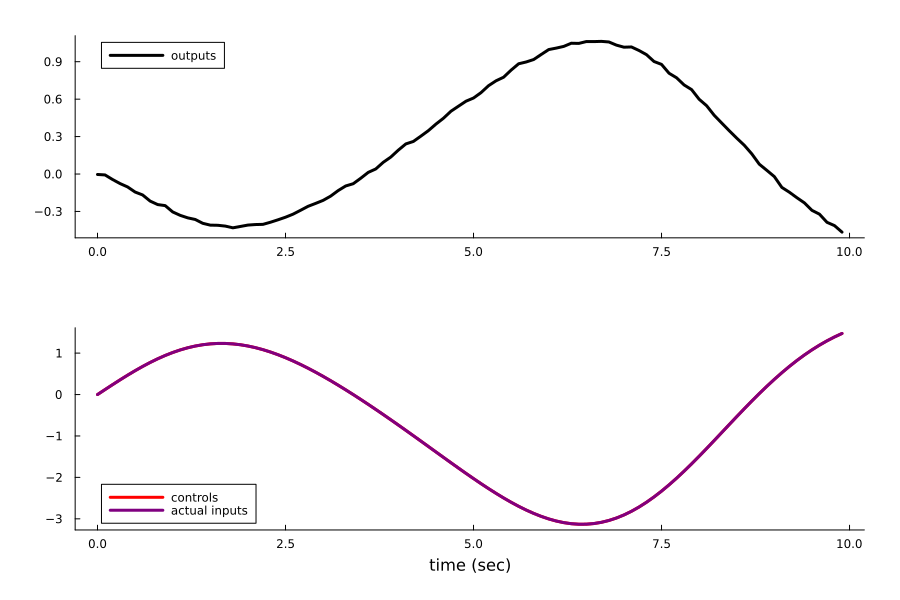

In [6]:
p101 = plot(tsteps, outputs, color="black", label="outputs")
p102 = plot(tsteps, controls, color="red", label="controls", xlabel="time (sec)")
plot!(tsteps, inputs, color="purple", label="actual inputs", xlabel="time (sec)")
plot(p101, p102, layout=grid(2,1), size=(900,600))

## NARX parameter estimation

In [7]:
# Polynomial degree
H = 1

# Delay order
Ly = M_out
Lu = M_in

# Model order
M = size(ϕ(zeros(Ly+Lu), degree=H),1);

In [8]:
# Specify prior distributions
pτ0 = GammaShapeRate(1e1, 1e0)
pθ0 = MvNormalMeanCovariance(ones(M), 1e3diagm(ones(M)))

MvNormalMeanCovariance(
μ: [1.0, 1.0, 1.0, 1.0, 1.0]
Σ: [1000.0 0.0 … 0.0 0.0; 0.0 1000.0 … 0.0 0.0; … ; 0.0 0.0 … 1000.0 0.0; 0.0 0.0 … 0.0 1000.0]
)


In [9]:
agent = NARXAgent(pθ0, pτ0, delay_in=Lu, delay_out=Ly, pol_degree=H)

NARXAgent(FactorGraphModel(), Constraints:
  marginals form:
  messages form:
  factorisation:
    q(θ, τ) = q(θ)q(τ)
Options:
  warn = true
, [Inf], MvNormalMeanCovariance(
μ: [1.0, 1.0, 1.0, 1.0, 1.0]
Σ: [1000.0 0.0 … 0.0 0.0; 0.0 1000.0 … 0.0 0.0; … ; 0.0 0.0 … 1000.0 0.0; 0.0 0.0 … 0.0 1000.0]
)
, GammaShapeRate{Float64}(a=10.0, b=1.0), NormalMeanVariance{Float64}(μ=0.0, v=1.0), 1, 10, 1.0, 2, 2, 1, 5, [0.0, 0.0], [0.0, 0.0])

In [10]:
py = []
qθ = [pθ0]
qτ = [pτ0]
FE = zeros(10,N)

T = 1
@showprogress for k in 1:(N-T)
    
    # Make predictions
    push!(py, predictions(agent, controls[k:k+T], time_horizon=T))
    
    # Update beliefs
    NARXAgents.update!(agent, outputs[k], controls[k])
    push!(qθ, agent.qθ)
    push!(qτ, agent.qτ)
    
    # Evaluate
    FE[:,k] = agent.free_energy
end

Progress:   2%|▉                                        |  ETA: 0:11:11

Progress: 100%|█████████████████████████████████████████| Time: 0:00:14


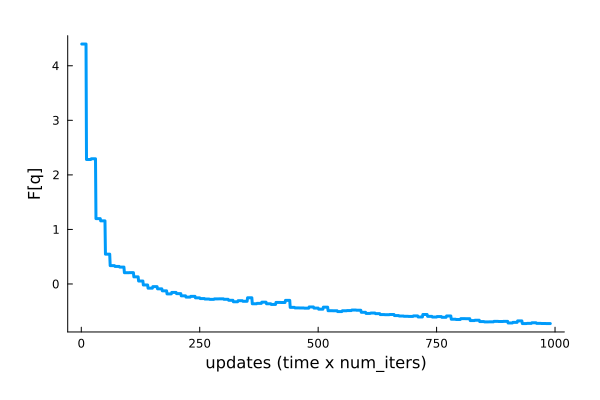

In [11]:
plot(reshape(FE[:,1:(N-T)], (10*(N-T),)), xlabel="updates (time x num_iters)", ylabel="F[q]")

In [12]:
mθ = cat(mean.(qθ)...,dims=2)
vθ = cat( var.(qθ)...,dims=2)

5×100 Matrix{Float64}:
 1000.0     0.0999895     0.0993031    0.0986745  …  0.000833153  0.000820471
 1000.0  1000.0         999.083      999.083         5.62732      5.46504
 1000.0  1000.0        1000.0        999.107         3.63595      3.40553
 1000.0  1000.0          14.6442      14.2427        2.20209      2.16622
 1000.0  1000.0        1000.0         40.2005        4.61687      4.57024

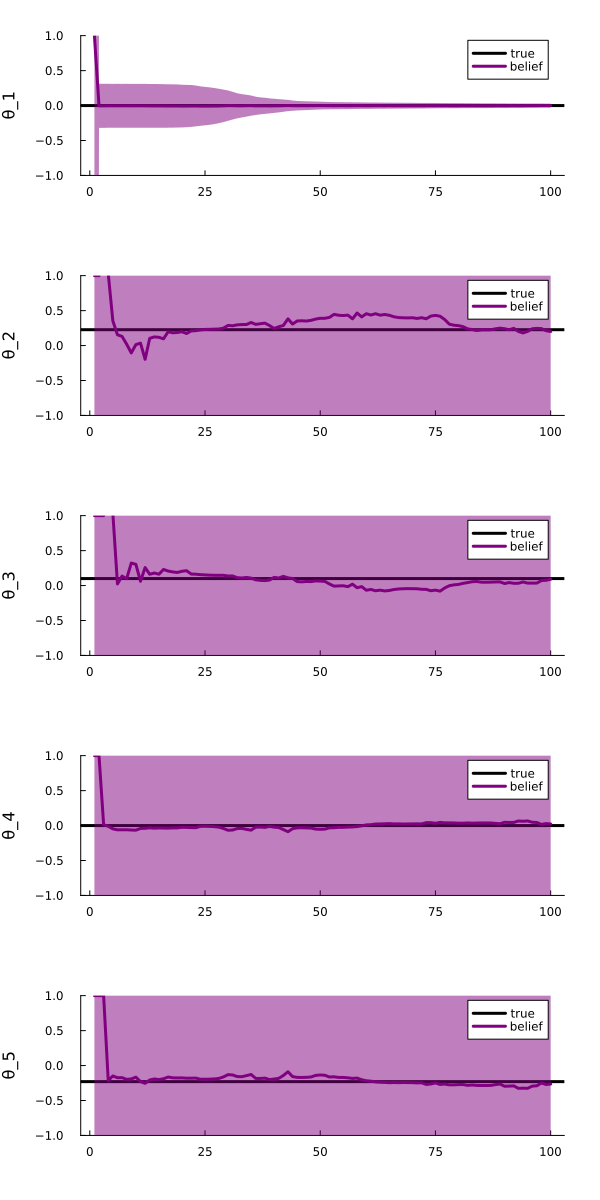

In [13]:
pw = []
for m in 1:M
    pwm = plot(ylims=(-1.,1.))
    
    hline!([sys_coefficients[m]], color="black", label="true")
    plot!(mθ[m,:], ribbon=sqrt.(vθ[m,:]), color="purple", label="belief", ylabel="θ_$m")
    
    push!(pw,pwm)
end
plot(pw..., layout=(M,1), size=(600,1200))

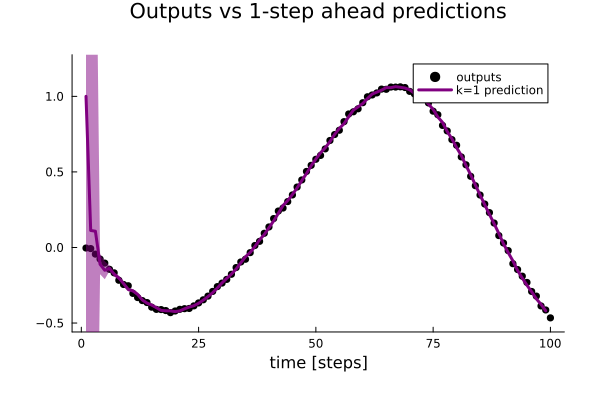

In [14]:
limsb = [minimum(outputs)*1.2, maximum(outputs)*1.2]
K = 1

p1 = plot(xlabel="time [steps]", title="Outputs vs $K-step ahead predictions", ylims=limsb)
scatter!(outputs, color="black", label="outputs")
plot!([mean(py[k][K]) for k in 1:(N-T)], ribbon=[var(py[k][K]) for k in 1:(N-T)], color="purple", label="k=$K prediction")

## Experiments

In [15]:
# Length of trial
N = 100
tsteps = range(0.0, step=Δt, length=N)
T = 10

# Set control properties
goal = NormalMeanVariance(1.0, 1e-3)
control_prior = 0.0
num_iters = 10
u_lims = (-3., 3.)
tlimit = 300

# Specify prior distributions
pτ0 = GammaShapeRate(1e0, 1e0)
pθ0 = MvNormalMeanCovariance(ones(M), 1e1diagm(ones(M)))

MvNormalMeanCovariance(
μ: [1.0, 1.0, 1.0, 1.0, 1.0]
Σ: [10.0 0.0 … 0.0 0.0; 0.0 10.0 … 0.0 0.0; … ; 0.0 0.0 … 10.0 0.0; 0.0 0.0 … 0.0 10.0]
)


### Mean Squared Error minimization

In [16]:
# Start system
system = ARXsys(sys_coefficients, 
                sys_mnoise_sd, 
                order_outputs=M_out, 
                order_inputs=M_in)

# Start agent
agent = NARXAgent(pθ0, pτ0, 
                  goal_prior=goal, 
                  delay_in=Lu, 
                  delay_out=Ly, 
                  pol_degree=H,
                  thorizon=T,
                  control_prior=control_prior,
                  num_iters=num_iters)

# Preallocate
y_MSE = zeros(N)
u_MSE = zeros(N+1)
pτ_MSE = [pτ0]
pθ_MSE = [pθ0]
py_MSE = []
FE_MSE = zeros(num_iters, N)

@showprogress for k in 1:N
    
    # Act upon environment
    ARXsystem.update!(system, u_MSE[k])
    y_MSE[k] = system.observation
    
    # Update parameter beliefs
    NARXAgents.update!(agent, y_MSE[k], u_MSE[k])
    
    FE_MSE[:,k] = agent.free_energy
    push!(pθ_MSE, agent.qθ)
    push!(pτ_MSE, agent.qτ)
    
    # Optimal control
    policy = minimizeMSE(agent, time_limit=tlimit, control_lims=u_lims)
    u_MSE[k+1] = policy[1]
    
    # Store future predictions
    push!(py_MSE, predictions(agent, policy, time_horizon=T))
    
end

Progress:   2%|▉                                        |  ETA: 0:04:25

Progress:   4%|█▋                                       |  ETA: 0:02:12

Progress:   6%|██▌                                      |  ETA: 0:01:28

Progress:  16%|██████▌                                  |  ETA: 0:00:30

Progress:  25%|██████████▎                              |  ETA: 0:00:18

Progress:  34%|██████████████                           |  ETA: 0:00:12

Progress:  42%|█████████████████▎                       |  ETA: 0:00:08

Progress:  51%|████████████████████▉                    |  ETA: 0:00:06

Progress:  60%|████████████████████████▋                |  ETA: 0:00:04

Progress:  69%|████████████████████████████▎            |  ETA: 0:00:03

Progress:  78%|████████████████████████████████         |  ETA: 0:00:02

Progress:  87%|███████████████████████████████████▋     |  ETA: 0:00:01

Progress:  96%|███████████████████████████████████████▍ |  ETA: 0:00:00

Progress: 100%|█████████████████████████████████████████| Time: 0:00:06


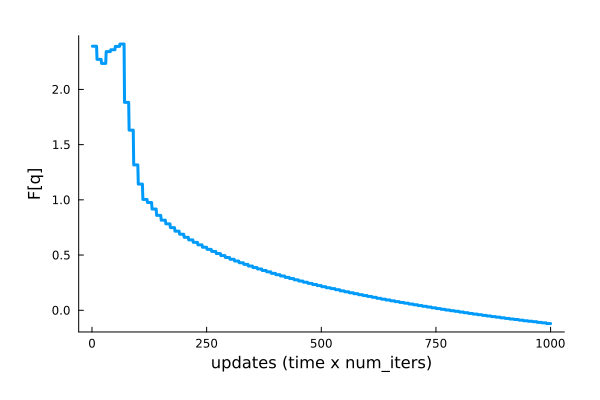

In [17]:
plot(FE_MSE[:], xlabel="updates (time x num_iters)", ylabel="F[q]")

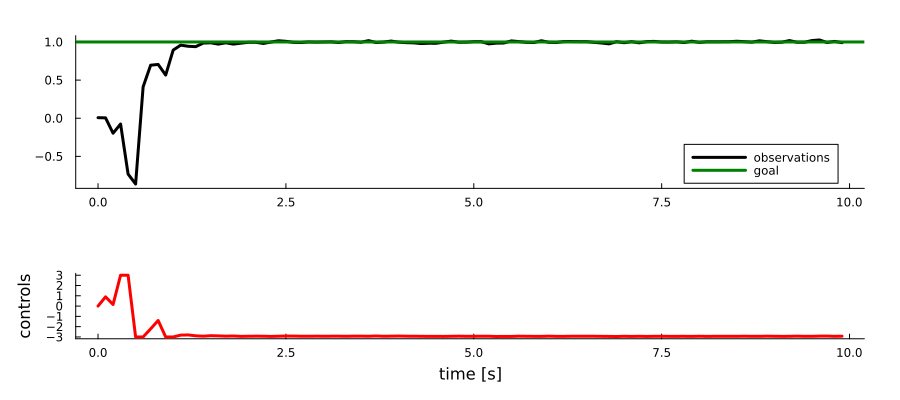

In [18]:
p1 = plot(tsteps, y_MSE, color="black", label="observations")
hline!([mean(goal)], color="green", label="goal")
p4 = plot(tsteps, u_MSE[1:end-1], color="red", ylabel="controls", xlabel="time [s]")

plot(p1,p4, layout=grid(2,1, heights=[.7, .3]), size=(900,400))

In [19]:
savefig("figures/NARX-MSE-verification-trial.png")

"/home/wmkouw/syndr/Wouter/Onderzoek/Projecten/tue/efe-acquisition/narx-efe/verification/figures/NARX-MSE-verification-trial.png"

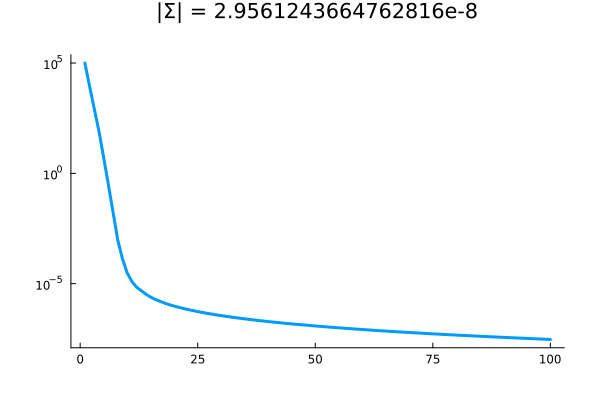

In [20]:
dSθ_MSE = [det(cov(pθ_MSE[k])) for k in 1:N]
final_dSθ_MSE = dSθ_MSE[end]
plot(dSθ_MSE, title="|Σ| = $final_dSθ_MSE", yscale=:log10)

┌ Info: Saved animation to /home/wmkouw/syndr/Wouter/Onderzoek/Projecten/tue/efe-acquisition/narx-efe/verification/figures/NARX-MSE-verification-planning.gif
└ @ Plots /home/wmkouw/.julia/packages/Plots/3BCH5/src/animation.jl:156


Plots.AnimatedGif("/home/wmkouw/syndr/Wouter/Onderzoek/Projecten/tue/efe-acquisition/narx-efe/verification/figures/NARX-MSE-verification-planning.gif")
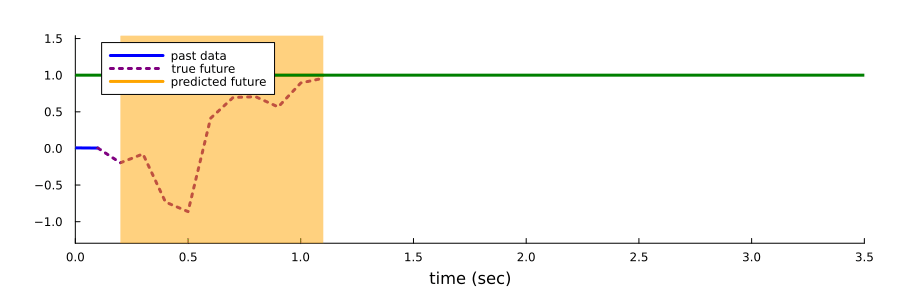

In [21]:
limsb = [minimum(y_MSE)*1.5, maximum(y_MSE)*1.5]

window = 20

anim = @animate for k in 2:(N-T-1)
    
    if k <= window
        plot(tsteps[1:k], y_MSE[1:k], color="blue", xlims=(tsteps[1], tsteps[window+T+1]+0.5), label="past data", xlabel="time (sec)", ylims=limsb, size=(900,300))
        plot!(tsteps[k:k+T], y_MSE[k:k+T], color="purple", label="true future", linestyle=:dot)
        plot!(tsteps[k+1:k+T], mean.(py_MSE[k]), ribbon=var.(py_MSE[k]), label="predicted future", color="orange", legend=:topleft)
        hline!([mean(goal)], color="green")
    else
        plot(tsteps[k-window:k], y_MSE[k-window:k], color="blue", xlims=(tsteps[k-window], tsteps[k+T+1]+0.5), label="past data", xlabel="time (sec)", ylims=limsb, size=(900,300))
        plot!(tsteps[k:k+T], y_MSE[k:k+T], color="purple", label="true future", linestyle=:dot)
        plot!(tsteps[k+1:k+T], mean.(py_MSE[k]), ribbon=var.(py_MSE[k]), label="prediction", color="orange", legend=:topleft)
        hline!([mean(goal)], color="green")
    end
    
end
gif(anim, "figures/NARX-MSE-verification-planning.gif", fps=24)

### Expected Free Energy minimization

In [22]:
# Start system
system = ARXsys(sys_coefficients, 
                sys_mnoise_sd, 
                order_outputs=M_out, 
                order_inputs=M_in)

# Start agent
agent = NARXAgent(pθ0, pτ0, 
                  goal_prior=goal, 
                  delay_in=Lu, 
                  delay_out=Ly, 
                  pol_degree=H,
                  thorizon=T,
                  control_prior=control_prior,
                  num_iters=num_iters)

# Preallocate
y_EFE = zeros(N)
u_EFE = zeros(N+1)
pτ_EFE = [pτ0]
pθ_EFE = [pθ0]
py_EFE = []
FE_EFE = zeros(num_iters, N)

@showprogress for k in 1:N
    
    # Act upon environment
    ARXsystem.update!(system, u_EFE[k])
    y_EFE[k] = system.observation
    
    # Update parameter beliefs
    NARXAgents.update!(agent, y_EFE[k], u_EFE[k])
    
    FE_EFE[:,k] = agent.free_energy
    push!(pθ_EFE, agent.qθ)
    push!(pτ_EFE, agent.qτ)
    
    # Optimal control
    policy = minimizeEFE(agent, time_limit=tlimit, control_lims=u_lims)
    u_EFE[k+1] = policy[1]
    
    # Store future predictions
    push!(py_EFE, predictions(agent, policy, time_horizon=T))
    
end

Progress:   2%|▉                                        |  ETA: 0:01:47

Progress:   7%|██▉                                      |  ETA: 0:00:31

Progress:  10%|████▏                                    |  ETA: 0:00:23

Progress:  13%|█████▍                                   |  ETA: 0:00:18

Progress:  17%|███████                                  |  ETA: 0:00:13

Progress:  20%|████████▎                                |  ETA: 0:00:11

Progress:  23%|█████████▍                               |  ETA: 0:00:10

Progress:  26%|██████████▋                              |  ETA: 0:00:11

Progress:  31%|████████████▊                            |  ETA: 0:00:09

Progress:  39%|████████████████                         |  ETA: 0:00:06

Progress:  47%|███████████████████▎                     |  ETA: 0:00:05

Progress:  55%|██████████████████████▌                  |  ETA: 0:00:03

Progress:  63%|█████████████████████████▉               |  ETA: 0:00:03

Progress:  70%|████████████████████████████▊            |  ETA: 0:00:02

Progress:  77%|███████████████████████████████▋         |  ETA: 0:00:01

Progress:  85%|██████████████████████████████████▉      |  ETA: 0:00:01

Progress:  92%|█████████████████████████████████████▊   |  ETA: 0:00:00

Progress:  98%|████████████████████████████████████████▏|  ETA: 0:00:00

Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


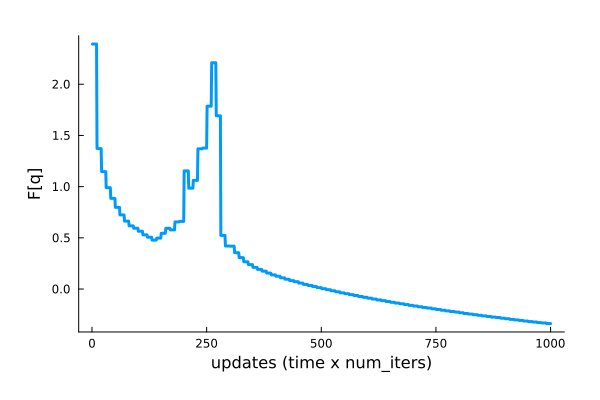

In [23]:
plot(FE_EFE[:], xlabel="updates (time x num_iters)", ylabel="F[q]")

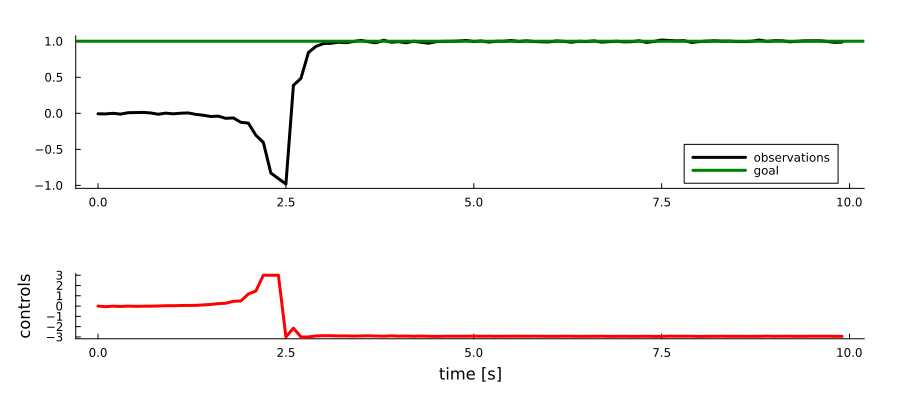

In [24]:
p1 = plot(tsteps, y_EFE, color="black", label="observations")
hline!([mean(goal)], color="green", label="goal")
p4 = plot(tsteps, u_EFE[1:end-1], color="red", ylabel="controls", xlabel="time [s]")

plot(p1,p4, layout=grid(2,1, heights=[.7, .3]), size=(900,400))

In [25]:
savefig("figures/NARX-EFE-verification-trial.png")

"/home/wmkouw/syndr/Wouter/Onderzoek/Projecten/tue/efe-acquisition/narx-efe/verification/figures/NARX-EFE-verification-trial.png"

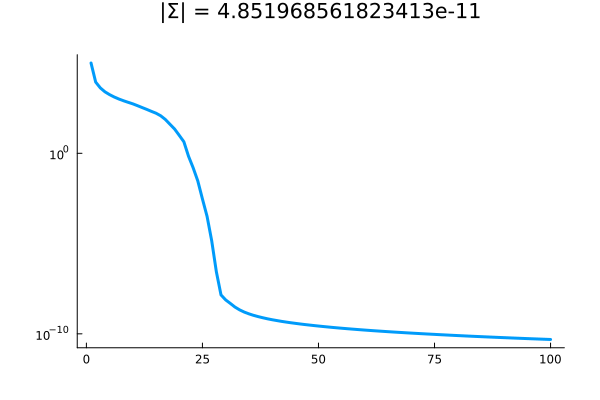

In [26]:
dSθ_EFE = [det(cov(pθ_EFE[k])) for k in 1:N]
final_dSθ_EFE = dSθ_EFE[end]
plot(dSθ_EFE, title="|Σ| = $final_dSθ_EFE", yscale=:log10)

┌ Info: Saved animation to /home/wmkouw/syndr/Wouter/Onderzoek/Projecten/tue/efe-acquisition/narx-efe/verification/figures/NARX-EFE-verification-planning.gif
└ @ Plots /home/wmkouw/.julia/packages/Plots/3BCH5/src/animation.jl:156


Plots.AnimatedGif("/home/wmkouw/syndr/Wouter/Onderzoek/Projecten/tue/efe-acquisition/narx-efe/verification/figures/NARX-EFE-verification-planning.gif")
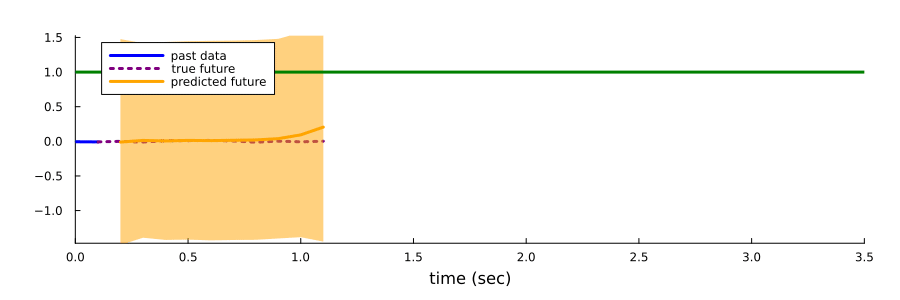

In [27]:
limsb = [minimum(y_EFE)*1.5, maximum(y_EFE)*1.5]

window = 20

anim = @animate for k in 2:(N-T-1)
    
    if k <= window
        plot(tsteps[1:k], y_EFE[1:k], color="blue", xlims=(tsteps[1], tsteps[window+T+1]+0.5), label="past data", xlabel="time (sec)", ylims=limsb, size=(900,300))
        plot!(tsteps[k:k+T], y_EFE[k:k+T], color="purple", label="true future", linestyle=:dot)
        plot!(tsteps[k+1:k+T], mean.(py_EFE[k]), ribbon=var.(py_EFE[k]), label="predicted future", color="orange", legend=:topleft)
        hline!([mean(goal)], color="green")
    else
        plot(tsteps[k-window:k], y_EFE[k-window:k], color="blue", xlims=(tsteps[k-window], tsteps[k+T+1]+0.5), label="past data", xlabel="time (sec)", ylims=limsb, size=(900,300))
        plot!(tsteps[k:k+T], y_EFE[k:k+T], color="purple", label="true future", linestyle=:dot)
        plot!(tsteps[k+1:k+T], mean.(py_EFE[k]), ribbon=var.(py_EFE[k]), label="prediction", color="orange", legend=:topleft)
        hline!([mean(goal)], color="green")
    end
    
end
gif(anim, "figures/NARX-EFE-verification-planning.gif", fps=24)

### Comparison

In [28]:
println("Final |Σ| MSE = $final_dSθ_MSE")
println("Final |Σ| EFE = $final_dSθ_EFE")

Final |Σ| MSE = 2.9561243664762816e-8
Final |Σ| EFE = 4.851968561823413e-11


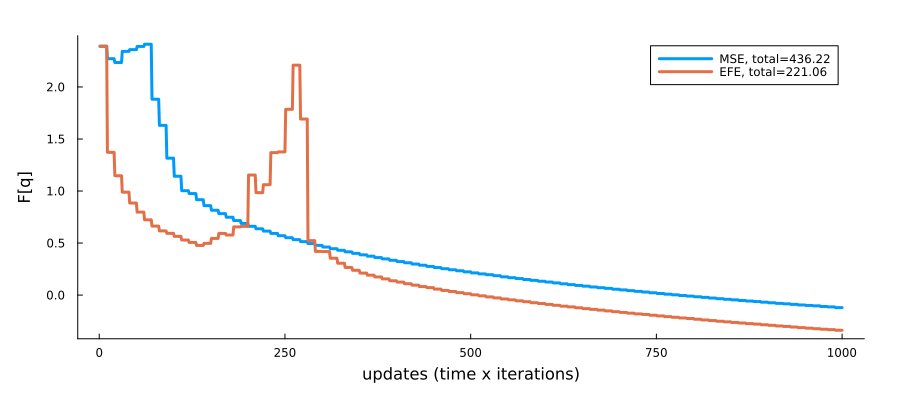

In [29]:
sF_MSE = round(sum(FE_MSE[:]), digits=2)
sF_EFE = round(sum(FE_EFE[:]), digits=2)

plot(xlabel="updates (time x iterations)", ylabel="F[q]", size=(900,400))
plot!(FE_MSE[:], label="MSE, total=$sF_MSE")
plot!(FE_EFE[:], label="EFE, total=$sF_EFE")

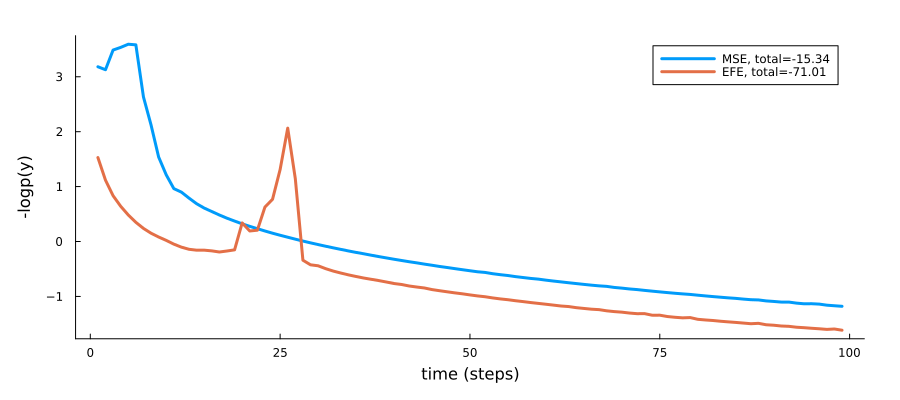

In [30]:
evidence_MSE = [-logpdf(py_MSE[k][1], y_MSE[k+1]) for k in 1:(N-1)]
evidence_EFE = [-logpdf(py_EFE[k][1], y_EFE[k+1]) for k in 1:(N-1)]

total_evidence_MSE = round(sum(evidence_MSE), digits=2)
total_evidence_EFE = round(sum(evidence_EFE), digits=2)

plot(xlabel="time (steps)", ylabel="-logp(y)", size=(900,400))
plot!(evidence_MSE, label="MSE, total=$total_evidence_MSE")
plot!(evidence_EFE, label="EFE, total=$total_evidence_EFE")

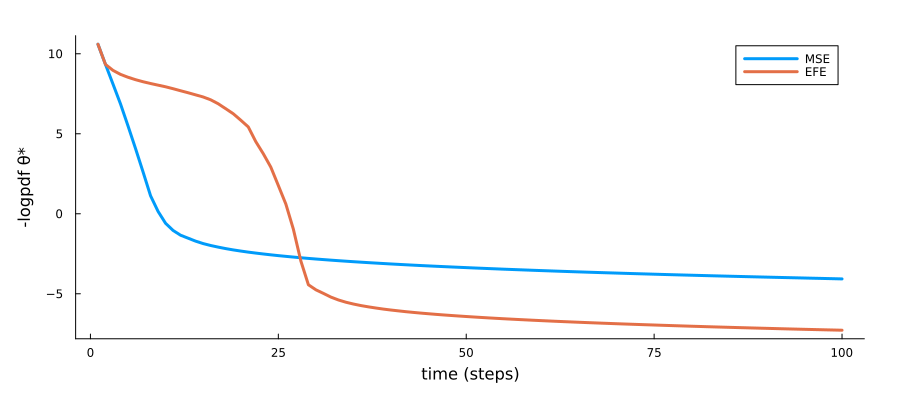

In [31]:
idθ_MSE = [-logpdf(pθ_MSE[k], sys_coefficients) for k in 1:N]
idθ_EFE = [-logpdf(pθ_EFE[k], sys_coefficients) for k in 1:N]

plot(xlabel="time (steps)", ylabel="-logpdf θ*", size=(900,400))
plot!(idθ_MSE, label="MSE")
plot!(idθ_EFE, label="EFE")

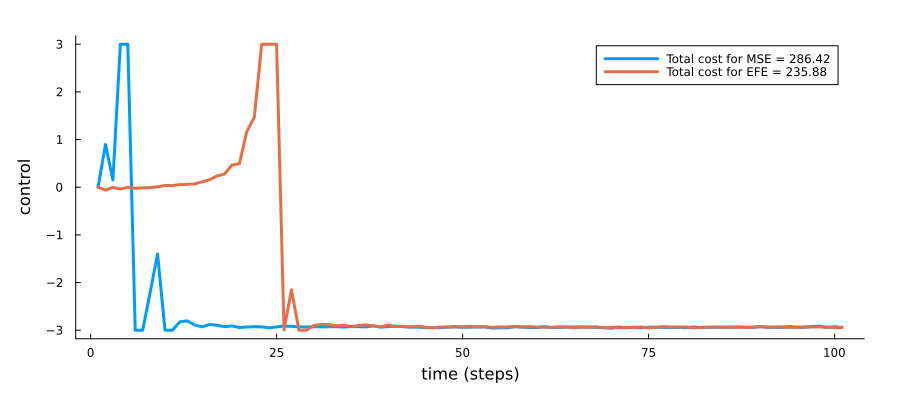

In [32]:
CC_MSE = round(sum(abs.(u_MSE)), digits=2)
CC_EFE = round(sum(abs.(u_EFE)), digits=2)

plot(xlabel="time (steps)", ylabel="control", size=(900,400))
plot!(u_MSE, label="Total cost for MSE = $CC_MSE")
plot!(u_EFE, label="Total cost for EFE = $CC_EFE")

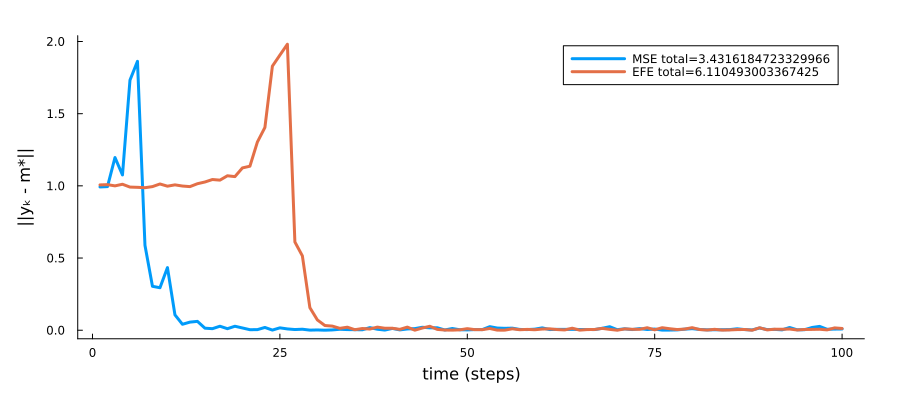

In [33]:
J_MSE = [norm(y_MSE[k] - mean(goal),2) for k in 1:N]
J_EFE = [norm(y_EFE[k] - mean(goal),2) for k in 1:N]

sJ_MSE = norm(y_MSE .- mean(goal),2)
sJ_EFE = norm(y_EFE .- mean(goal),2)

plot(xlabel="time (steps)", ylabel="||yₖ - m*||", size=(900,400))
plot!(J_MSE, label="MSE total=$sJ_MSE")
plot!(J_EFE, label="EFE total=$sJ_EFE")